# Projeto de Classificação Binária - Avaliação Completa

Neste notebook, iremos carregar os dados, ajustar e avaliar modelos RandomForest, incluindo seleção de variáveis e geração dos principais gráficos de avaliação.

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from scipy.stats import randint
import xgboost as xgb

sns.set(style="whitegrid")

In [2]:
# === 1. Carregar dados ===
df = pd.read_csv("../data/processed/ml_iq_2018_2023.csv")

variaveis_preditoras = [
    'NOTA_PADRONIZADA_-_IDD',
    'NOTA_PADRONIZADA_-_ORGANIZAÇÃO_DIDÁTICO-PEDAGÓGICA',
    'NOTA_PADRONIZADA_-_INFRAESTRUTURA_E_INSTALAÇÕES_FÍSICAS',
    'NOTA_PADRONIZADA_-_OPORTUNIDADE_DE_AMPLIAÇÃO_DA_FORMAÇÃO',
    'NOTA_PADRONIZADA_-_MESTRES',
    'NOTA_PADRONIZADA_-_DOUTORES',
    'MEDIA_CONCEITO_ENADE_(CONTÍNUO)',
    'IDD_(CONTÍNUO)',
    'CONCEITO_MÉDIO_DE_GRADUAÇÃO',
    'IGC_(CONTÍNUO)',
    'SALARIO',
    'QT_VG_TOTAL_MEDIA'
]

X = df[variaveis_preditoras]
y = df['TDA_binaria']

In [3]:
# === 2. Criar diretórios ===
output_dir_viz = "../outputs/visualizations"
output_dir_reports = "../outputs/reports"
output_dir_models = "../outputs/models"
os.makedirs(output_dir_viz, exist_ok=True)
os.makedirs(output_dir_reports, exist_ok=True)
os.makedirs(output_dir_models, exist_ok=True)

In [4]:
# === 3. Dividir dados em treino e teste ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [5]:
# === 4. Função para ajuste refinado ===
def ajustar_lista_certas(val, passo=50, minimo=10):
    return sorted(list(set([max(minimo, val - passo), val, val + passo])))

In [6]:
# === 5. RandomizedSearchCV para RandomForest ===
param_dist_rf = {
    'n_estimators': randint(100, 400),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf,
    n_iter=30, cv=StratifiedKFold(5),
    scoring='accuracy', n_jobs=-1, verbose=2,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_

param_grid_rf = {
    'n_estimators': ajustar_lista_certas(best_params_rf['n_estimators']),
    'max_depth': [best_params_rf['max_depth']] if best_params_rf['max_depth'] is not None else [None, 10, 20],
    'min_samples_split': ajustar_lista_certas(best_params_rf['min_samples_split'], passo=1, minimo=2),
    'min_samples_leaf': ajustar_lista_certas(best_params_rf['min_samples_leaf'], passo=1, minimo=1),
    'max_features': [best_params_rf['max_features']],
    'class_weight': [best_params_rf['class_weight']]
}

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(
    rf_grid, param_grid=param_grid_rf,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1, verbose=2
)

grid_search_rf.fit(X_train, y_train)

melhor_rf = grid_search_rf.best_estimator_

joblib.dump(melhor_rf, os.path.join(output_dir_models, "randomforest_final.pkl"))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


['../outputs/models\\randomforest_final.pkl']

In [7]:
# === 6. RandomizedSearchCV para XGBoost ===
param_dist_xgb = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.5, 2, 3]
}

xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)

random_search_xgb = RandomizedSearchCV(
    xgb_clf, param_distributions=param_dist_xgb,
    n_iter=30, cv=StratifiedKFold(5),
    scoring='accuracy', n_jobs=-1, verbose=2,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

melhor_xgb = random_search_xgb.best_estimator_

joblib.dump(melhor_xgb, os.path.join(output_dir_models, "xgboost_final.pkl"))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


['../outputs/models\\xgboost_final.pkl']

In [16]:
# === Função para avaliação do modelo final com gráficos ===
def avaliar_modelo_final(modelo, X_treino, y_treino, X_teste, y_teste, nome_modelo):
    modelo.fit(X_treino, y_treino)
    y_pred = modelo.predict(X_teste)
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X_teste)[:, 1]
    else:
        y_prob = modelo.decision_function(X_teste)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

    acc = accuracy_score(y_teste, y_pred)
    cm = confusion_matrix(y_teste, y_pred)
    cr = classification_report(y_teste, y_pred)

    print(f"\nModelo: {nome_modelo}")
    print(f"Acurácia: {acc:.4f}")
    print("Matriz de Confusão:\n", cm)
    print("Relatório de Classificação:\n", cr)

    df_report = pd.DataFrame(classification_report(y_teste, y_pred, output_dict=True)).transpose()
    df_report.to_csv(os.path.join(output_dir_reports, f"{nome_modelo}_classification_report.csv"))

    # === Matriz de Confusão ===
    plt.figure(figsize=(7, 6))
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", cbar=True,
                xticklabels=['Previsto 0', 'Previsto 1'], yticklabels=['Real 0', 'Real 1'])
    plt.title(f"Matriz de Confusão Normalizada - {nome_modelo}")
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Real")
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_confusion_matrix.png"))
    plt.show()

    # === Importância das Variáveis ===
    if hasattr(modelo, "feature_importances_"):
        plt.figure(figsize=(10, 6))
        importancias = modelo.feature_importances_
        variaveis = X_treino.columns
        sorted_idx = np.argsort(importancias)[::-1]
        importancias_sorted = importancias[sorted_idx]
        variaveis_sorted = variaveis[sorted_idx]
        colors = sns.color_palette("viridis", len(importancias_sorted))

        sns.barplot(x=importancias_sorted, y=variaveis_sorted, palette=colors)
        plt.title(f"Importância das Variáveis - {nome_modelo}")
        plt.xlabel("Importância")
        plt.ylabel("Variáveis")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_feature_importance.png"))
        plt.show()

    # === Curva ROC ===
    fpr, tpr, _ = roc_curve(y_teste, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Taxa de Falso Positivo (FPR)")
    plt.ylabel("Taxa de Verdadeiro Positivo (TPR)")
    plt.title(f"Curva ROC - {nome_modelo}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_roc_curve.png"))
    plt.show()

    # === Curva Precisão-Recall ===
    precision, recall, _ = precision_recall_curve(y_teste, y_prob)
    avg_precision = average_precision_score(y_teste, y_prob)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, lw=2, label=f'PR Curve (AP = {avg_precision:.3f})')
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.title(f"Curva Precisão-Recall - {nome_modelo}")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_precision_recall_curve.png"))
    plt.show()

    # === Gráfico de Calibração ===
    fop, mpv = calibration_curve(y_teste, y_prob, n_bins=10, strategy='uniform')
    plt.figure(figsize=(7, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Calibração Perfeita')
    plt.plot(mpv, fop, marker='o', lw=1, label=nome_modelo)
    plt.xlabel("Média de Probabilidade Prevista")
    plt.ylabel("Fração de Positivos")
    plt.title(f"Gráfico de Calibração - {nome_modelo}")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_calibration_plot.png"))
    plt.show()

    # === Distribuição de Probabilidades ===
    plt.figure(figsize=(9, 6))
    sns.histplot(y_prob[y_teste == 0], color='blue', label='Classe Real 0', kde=True, stat='density', alpha=0.6)
    sns.histplot(y_prob[y_teste == 1], color='red', label='Classe Real 1', kde=True, stat='density', alpha=0.6)
    plt.title(f"Distribuição de Probabilidades - {nome_modelo}")
    plt.xlabel("Probabilidade Prevista da Classe Positiva")
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_probability_distribution.png"))
    plt.show()

    # === Gráficos de Resíduos ===
    residuos = y_teste - y_prob
    media_res = np.mean(residuos)
    desvio_res = np.std(residuos)
    residuos_padronizados = (residuos - media_res) / desvio_res

    # === Resíduos Padronizados ===
    plt.figure(figsize=(9, 6))
    plt.scatter(range(len(residuos_padronizados)), residuos_padronizados, alpha=0.6, color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='red', linestyle='--')
    plt.title(f"Gráfico de Resíduos Padronizados - {nome_modelo}")
    plt.xlabel("Observação")
    plt.ylabel("Resíduo Padronizado")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_residuals_standardized.png"))
    plt.show()

    # === Resíduos vs Probabilidade Prevista ===
    plt.figure(figsize=(9, 6))
    plt.scatter(y_prob, residuos_padronizados, alpha=0.6, color='green')
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='red', linestyle='--')
    plt.title(f"Resíduos Padronizados vs Probabilidade Prevista - {nome_modelo}")
    plt.xlabel("Probabilidade Prevista")
    plt.ylabel("Resíduo Padronizado")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_residuals_vs_prob.png"))
    plt.show()

    return {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': cr,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'modelo': modelo
    }



Avaliando RandomForest Final:

Modelo: randomforest_final
Acurácia: 0.7166
Matriz de Confusão:
 [[154  67]
 [ 58 162]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71       221
           1       0.71      0.74      0.72       220

    accuracy                           0.72       441
   macro avg       0.72      0.72      0.72       441
weighted avg       0.72      0.72      0.72       441



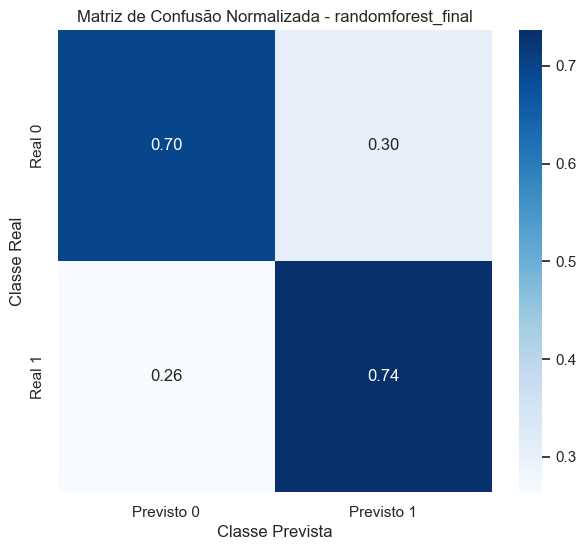

C:\Users\john-\AppData\Local\Temp\ipykernel_9792\1261192627.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias_sorted, y=variaveis_sorted, palette=colors)


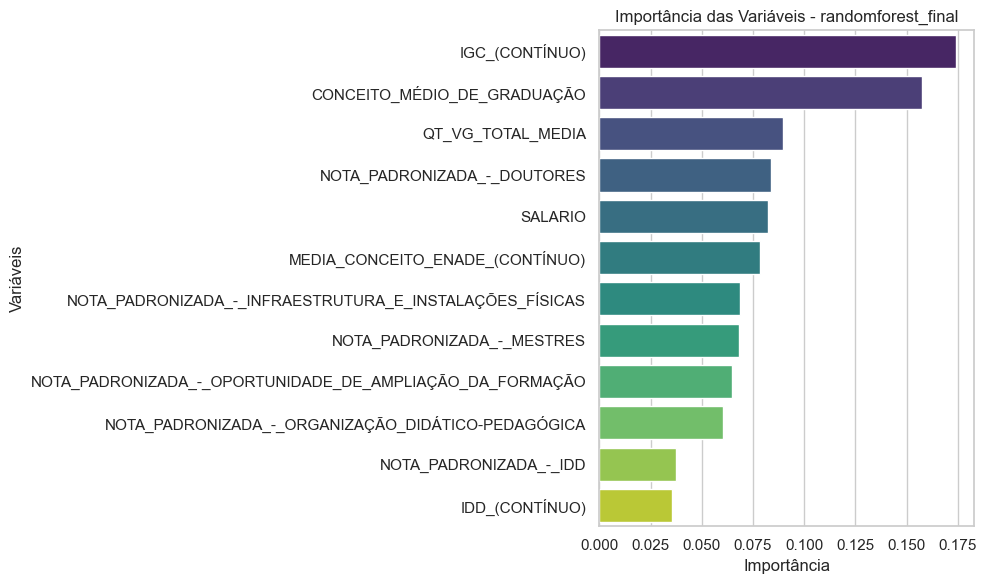

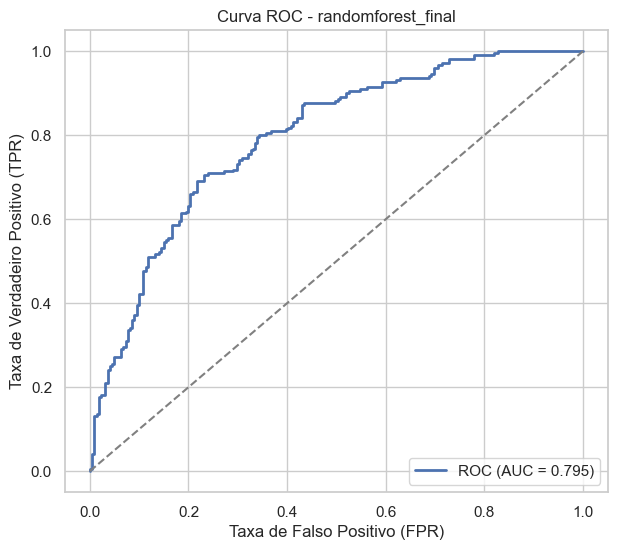

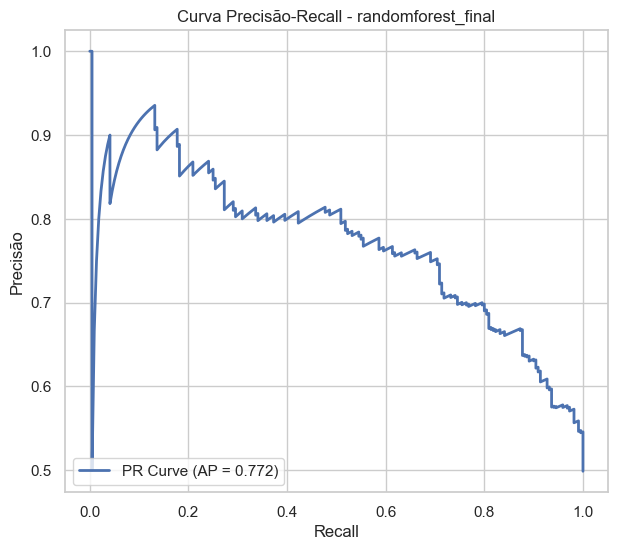

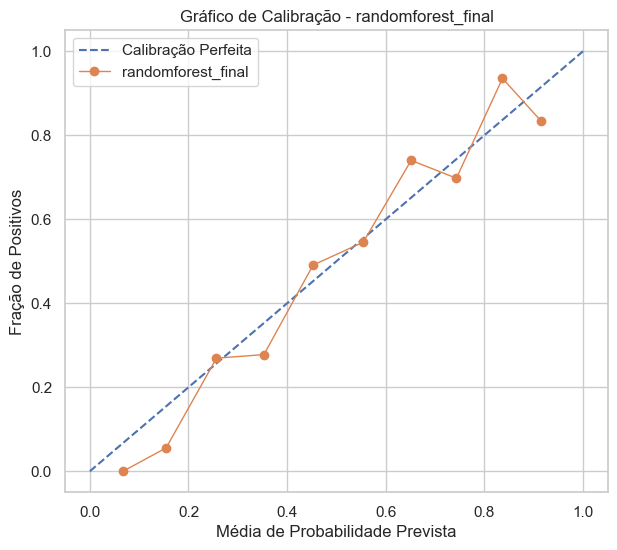

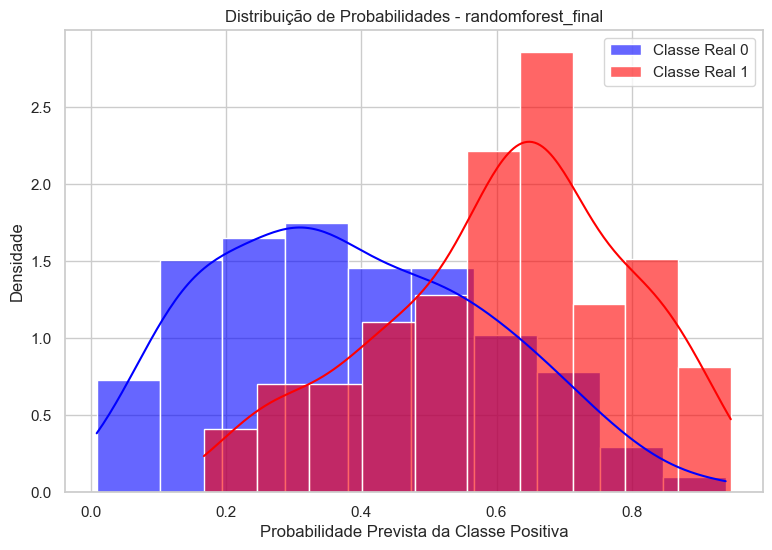

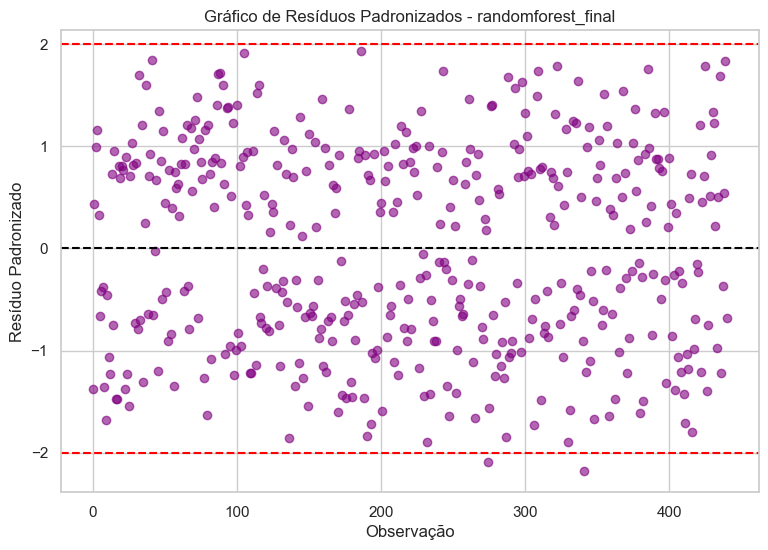

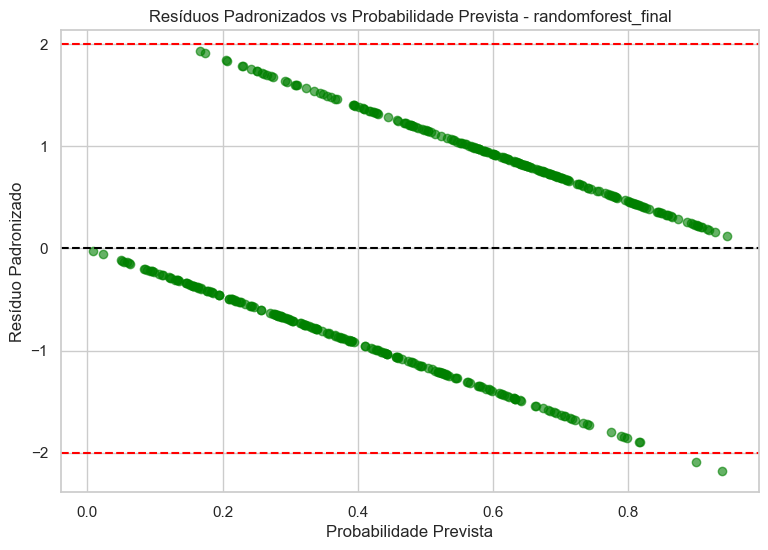


Avaliando XGBoost Final:

Modelo: xgboost_final
Acurácia: 0.7279
Matriz de Confusão:
 [[156  65]
 [ 55 165]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72       221
           1       0.72      0.75      0.73       220

    accuracy                           0.73       441
   macro avg       0.73      0.73      0.73       441
weighted avg       0.73      0.73      0.73       441



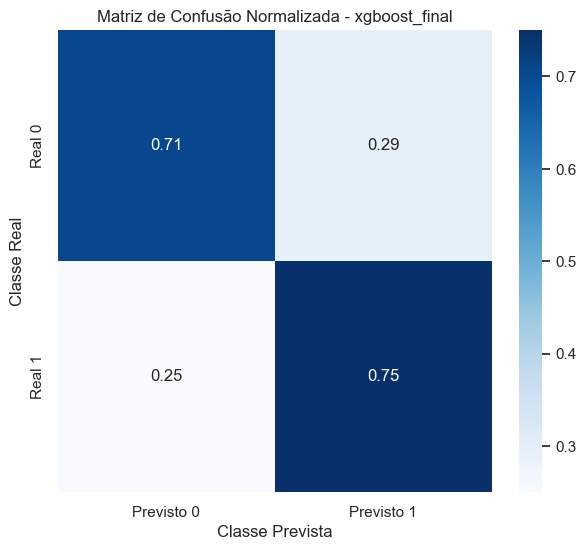

C:\Users\john-\AppData\Local\Temp\ipykernel_9792\1261192627.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias_sorted, y=variaveis_sorted, palette=colors)


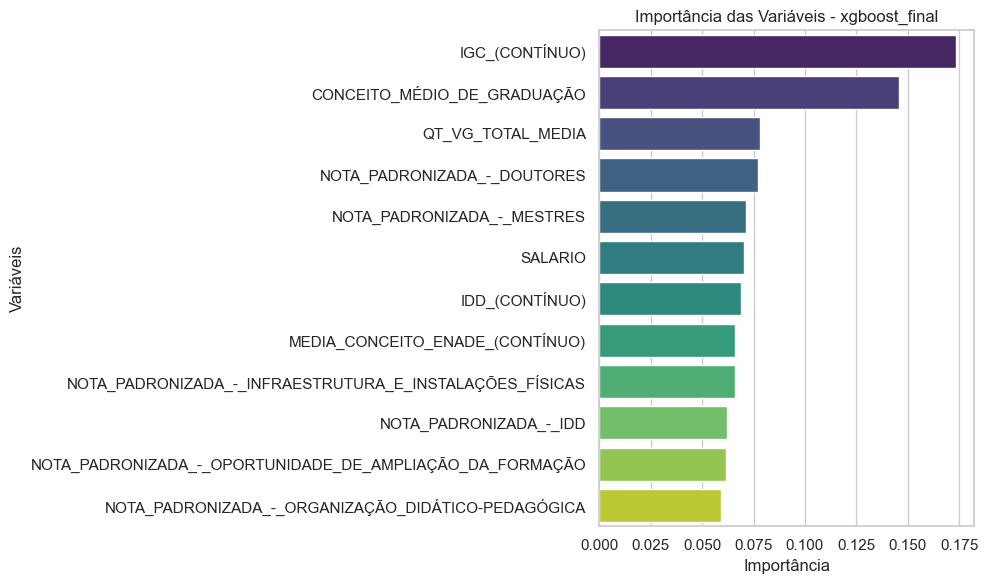

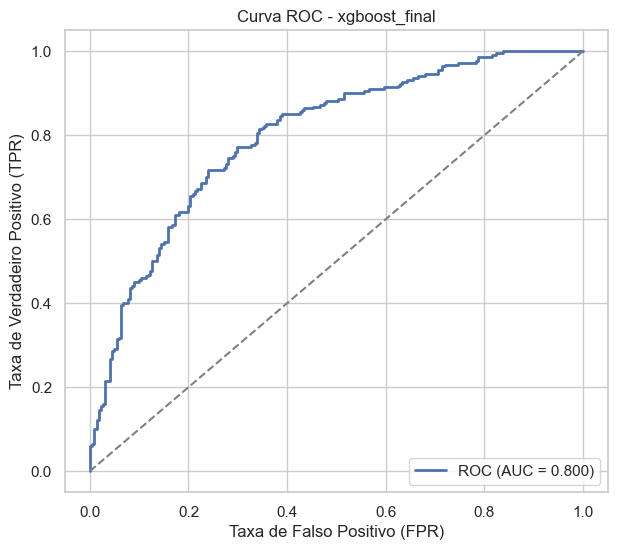

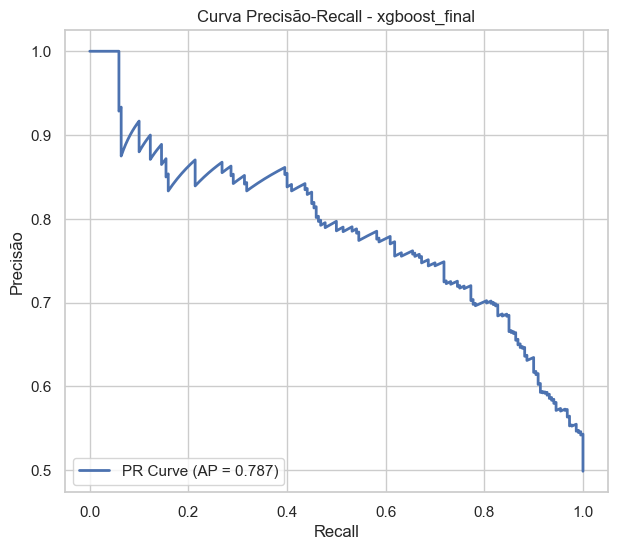

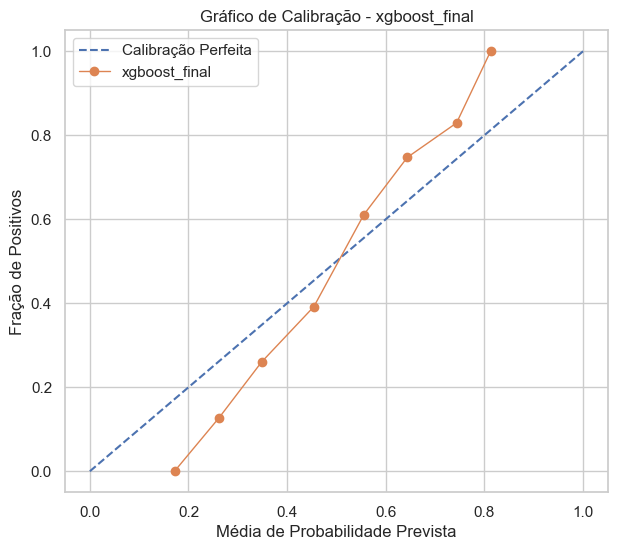

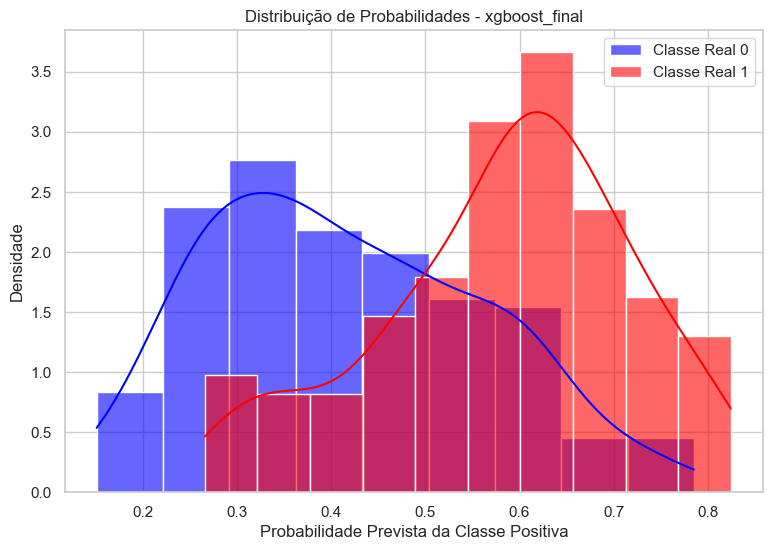

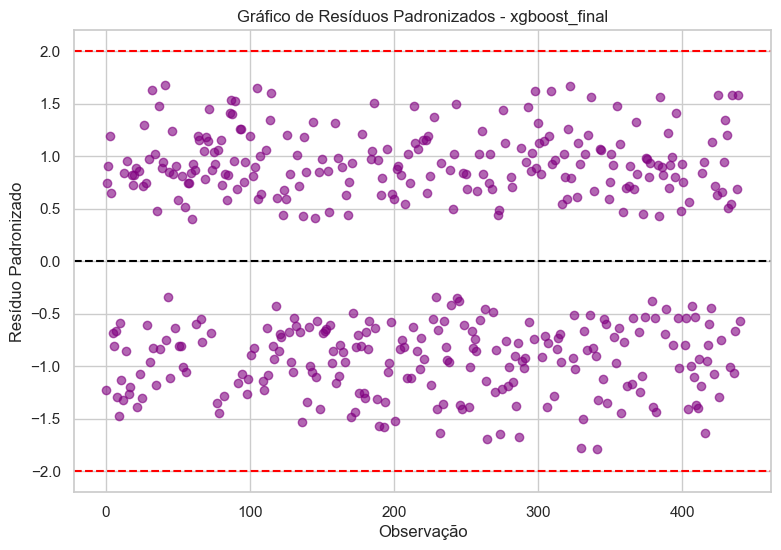

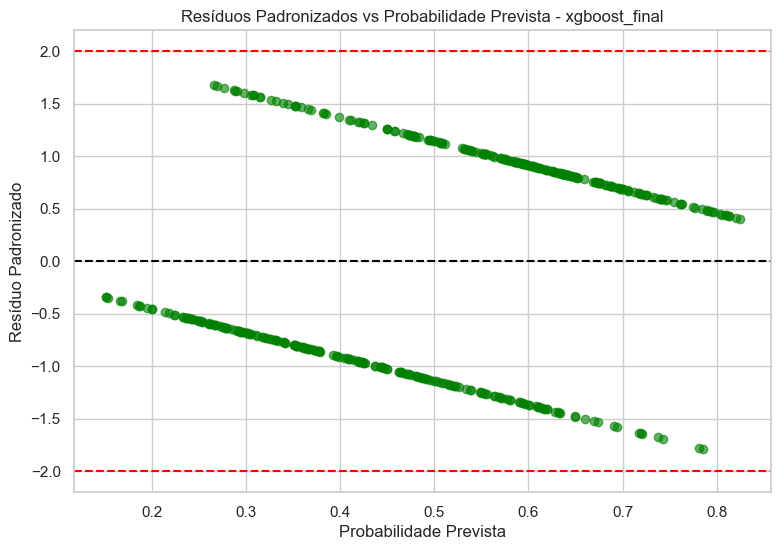

In [17]:
# === 8. Avaliar os modelos finais ===
print("\nAvaliando RandomForest Final:")
res_rf_final = avaliar_modelo_final(melhor_rf, X_train, y_train, X_test, y_test, "randomforest_final")

print("\nAvaliando XGBoost Final:")
res_xgb_final = avaliar_modelo_final(melhor_xgb, X_train, y_train, X_test, y_test, "xgboost_final")